In [6]:
from analyze_results import aggregate_runs, improvement_over_baseline, default_methods, collect_configs, aggregate_runs_de, calc_rejection_curve_auc_seq
from pathlib import Path
import pandas as pd
from ue4nlp.ue_scores import *

def create_section_col(runs_dir, metric='roc-auc', task_type='classification', de = False):
    runs_dir = Path(runs_dir) #/ 'results'
    if not runs_dir.is_dir():
        raise ValueError()
    #print(runs_dir)
    if 'ner' in task_type:
        default_methods = {
            "bald": bald,
            "var_ratio": var_ratio,
            "sampled_max_prob": sampled_max_prob,
            "variance": probability_variance,
        }
    else:
        default_methods = {
            "bald": bald,
            "sampled_max_prob": sampled_max_prob,
            "variance": probability_variance,
        }
        
    if de:
        agg_res = aggregate_runs_de(runs_dir, methods=default_methods, metric=metric)
    else:
        agg_res = aggregate_runs(runs_dir, methods=default_methods, metric=metric, task_type=task_type)
    #print(collect_configs(runs_dir))
    if agg_res.empty:
        print('Broken')
        print()
        raise ValueError()

    improvement = improvement_over_baseline(agg_res, baseline_col='max_prob', metric=metric)
    #print(improvement)
    print()
    return improvement


def build_eval_table(dataset_paths, metric='roc-auc', mc_types=None, task_type='classifiaction', de = False):
    BASELINE_INDEX = 'baseline (max_prob)'
    
    columns = []
    names = []
    for name, paths in dataset_paths.items():
        method_results = []
        baseline = None
        for path, dropout_type, layer in paths:
            if ('token' in name) and (task_type == 'ner'):
                task_type_full = task_type + '-token'
            elif (task_type == 'ner'):
                task_type_full = task_type + '-seq'
            else:
                task_type_full = task_type
            method_batch = create_section_col(path, metric, task_type_full, de)
            method_batch.drop(index=['count'], inplace=True)#, 'ens_accuracy', 'model_accuracy'
            baseline = method_batch[BASELINE_INDEX: BASELINE_INDEX]
            method_batch.drop(index=BASELINE_INDEX, inplace=True)
            method_batch = pd.Series(method_batch.values, index=[f'{dropout_type}|{layer}|{e}' for e in method_batch.index])
            
            #print(method_batch)
            method_results.append(method_batch)
        
        col = pd.concat([baseline] + method_results, axis=0)
        
        columns.append(col)
        names.append(name)
    
    name_map = {i : n for i,n in enumerate(names)}
    
    return pd.concat(columns, axis=1).rename(columns=name_map)

# Results with augmentations on GLUE datasets

In [2]:
tasks = ['cola', 'mrpc', 'sst2']
mc_types = ['DPP_last']
path = "../workdir/results/aug/results"

eval_table = build_eval_table(
    {
        'SST-2' : [
            (f'{path}/{tasks[2]}/', 'DPP_with_OOD_40/100', 'last'),
        ],
        'MRPC' : [
            (f'{path}/{tasks[1]}/', 'DPP_with_OOD_40/100', 'last'),
        ],
        'CoLA' : [
            (f'{path}/{tasks[0]}/', 'DPP_with_OOD_40/100', 'last'),
        ]
    },
    task_type='classification',
    metric='rejection-curve-auc'
)

eval_table

,SST-2,MRPC,CoLA
baseline (max_prob),0.924±0.005,0.882±0.021,0.732±0.039
DPP_with_OOD_40/100|last|bald,0.931±0.004,0.877±0.023,0.710±0.037
DPP_with_OOD_40/100|last|sampled_max_prob,0.937±0.001,0.896±0.019,0.721±0.044
DPP_with_OOD_40/100|last|variance,0.932±0.003,0.882±0.022,0.712±0.038


# Results with out-of-domain sampling on DPP masks on GLUE datasets

In [4]:
tasks = ['cola', 'mrpc', 'sst2']
mc_types = ['DPP_last']
path = "../workdir/results/dpp_masks_odd"

eval_table = build_eval_table(
    {
        'SST-2' : [
            (f'{path}/{tasks[2]}/ht_dpp/True/40/100/0.3', 'DPP_with_OOD_40/100', 'last'),
        ],
        'MRPC' : [
            (f'{path}/{tasks[1]}/ht_dpp/True/40/100/0.3', 'DPP_with_OOD_40/100', 'last'),
        ],
        'CoLA' : [
            (f'{path}/{tasks[0]}/ht_dpp/True/40/100/0.3', 'DPP_with_OOD_40/100', 'last'),
        ]
    },
    task_type='classification',
    metric='rejection-curve-auc'
)

eval_table

,SST-2,MRPC,CoLA
baseline (max_prob),0.939±0.001,0.929±0.003,0.923±0.003
DPP_with_OOD_40/100|last|bald,0.940±0.001,0.931±0.003,0.923±0.004
DPP_with_OOD_40/100|last|sampled_max_prob,0.940±0.001,0.931±0.002,0.924±0.003
DPP_with_OOD_40/100|last|variance,0.940±0.002,0.931±0.004,0.923±0.003


# Results with DPP sampling on DPP masks on CoNLL-2003

In [2]:
tasks = ['conll2003']
mc_types = ['DPP_last']
path = "../workdir/results/dpp_masks_calibrate"

eval_table = build_eval_table(
    {
        'CoNLL-2003 (token level)' : [
            (f'{path}/{tasks[0]}/ht_dpp/rbf/True/20/0.3', 'DPP_with_rbf/0.3', 'last'),
        ],
        'CoNLL-2003 (sequence level)' : [
            (f'{path}/{tasks[0]}/ht_dpp/rbf/True/20/0.3', 'DPP_with_rbf/0.3', 'last'),
        ]
    },
    task_type='ner',
    metric='rejection-curve-auc'
)

eval_table

,CoNLL-2003 (token level),CoNLL-2003 (sequence level)
baseline (max_prob),0.941±0.001,0.892±0.004
DPP_with_rbf/0.3|last|bald,0.938±0.001,0.835±0.012
DPP_with_rbf/0.3|last|var_ratio,0.946±0.000,0.853±0.008
DPP_with_rbf/0.3|last|sampled_max_prob,0.940±0.001,0.896±0.005
DPP_with_rbf/0.3|last|variance,0.939±0.001,0.829±0.012


# Results with DPP sampling on DPP masks on GLUE datasets

In [3]:
tasks = ['cola', 'mrpc', 'sst2']
mc_types = ['DPP_last']
path = "../workdir/results/dpp_masks_calibrate"

eval_table = build_eval_table(
    {
        'SST-2' : [
            (f'{path}/{tasks[2]}/ht_dpp/rbf/True/50/0.3/', 'DPP_on_masks', 'last'),
        ],
        'MRPC' : [
            (f'{path}/{tasks[1]}/ht_dpp/rbf/True/50/0.3/', 'DPP_on_masks', 'last'),
        ],
        'CoLA' : [
            (f'{path}/{tasks[0]}/ht_dpp/cosine/True/50/0.6/', 'DPP_on_masks', 'last'),
        ]
    },
    task_type='classification',
    metric='rejection-curve-auc'
)

eval_table

,SST-2,MRPC,CoLA
baseline (max_prob),0.940±0.002,0.929±0.003,0.922±0.002
DPP_on_masks|last|bald,0.941±0.001,0.929±0.004,0.922±0.003
DPP_on_masks|last|sampled_max_prob,0.940±0.002,0.930±0.003,0.922±0.002
DPP_on_masks|last|variance,0.941±0.001,0.929±0.004,0.922±0.003


In [7]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import ujson as json
import re
from sklearn.metrics import roc_curve

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_error_detection_seq, plot_error_detection, plot_rejection_curve_aucs


def plot_rejection_curves_ner(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
        
    probs = np.asarray(model_outputs['probabilities'])
    probs_toks = probs.reshape(-1, probs.shape[-1])
    
    sampled_probs = np.asarray(model_outputs['sampled_probabilities'])
    sampled_probs_toks = sampled_probs.reshape(sampled_probs.shape[0], sampled_probs.shape[1]*sampled_probs.shape[2], -1)
    
    labels = np.asarray(model_outputs['true_labels'])
    labels_toks = labels.reshape(-1)
    
    use_idx = (labels_toks!=-100)

    plot_rejection_curve_aucs(probs_toks[use_idx], 
                              labels_toks[use_idx], 
                              sampled_probs_toks[:, use_idx].transpose(1, 0, 2),
                              np.asarray(model_outputs['answers']).reshape(-1)[use_idx])

def plot_rejection_curves(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
    
    plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                              np.asarray(model_outputs['true_labels']), 
                              np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                              np.asarray(model_outputs['answers']), )

# DPP on CoNLL-2003

bald: 0.9381076204627468
var_ratio: 0.946941555225359
entropy: 0.9347325408618128
sampled_max_prob: 0.9408370480435859
variance: 0.9392025755324418
max_prob: 0.9410599306587419


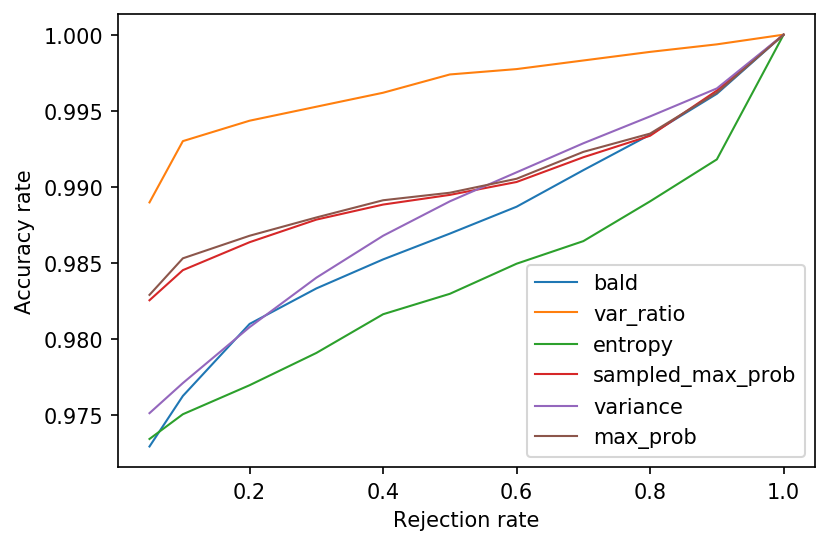

In [24]:
res_dir = '../workdir/results/dpp_masks_calibrate/conll2003/ht_dpp/rbf/True/20/0.3/101/17'
plot_rejection_curves_ner(res_dir)

# DPP on CoLA

bald: 0.9261744966442952
var_ratio: 0.9087967401725792
entropy: 0.9262224352828379
sampled_max_prob: 0.9262224352828379
variance: 0.9261025886864812
max_prob: 0.9253835091083412


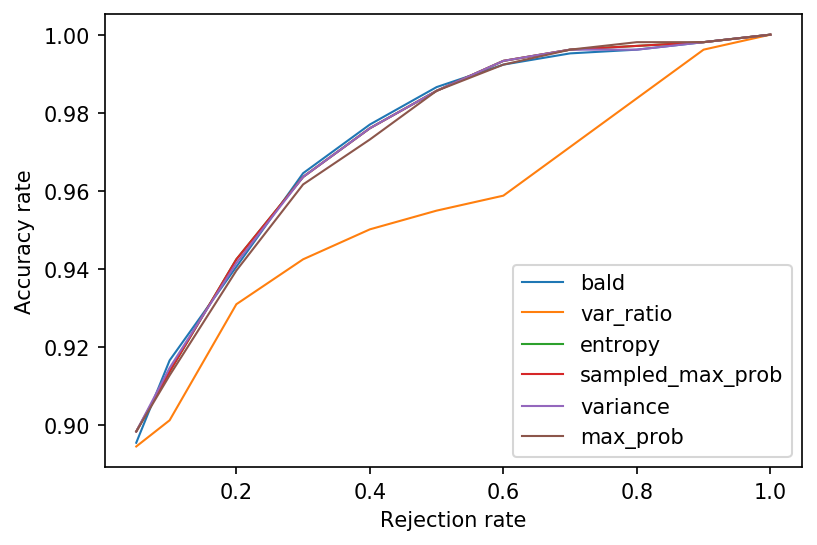

In [21]:
res_dir = '../workdir/results/dpp_masks_odd/cola/ht_dpp/True/40/100/0.3/102/42/'
plot_rejection_curves(res_dir)

# DPP on MRPC

bald: 0.9338848039215687
var_ratio: 0.909313725490196
entropy: 0.9329044117647058
sampled_max_prob: 0.9329044117647058
variance: 0.9341299019607844
max_prob: 0.9316176470588236


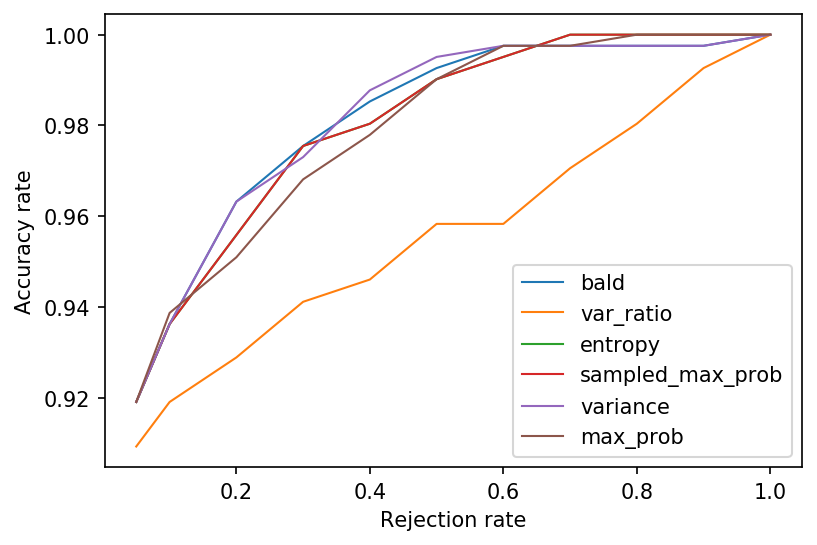

In [12]:
res_dir = '../workdir/results/dpp_masks_odd/mrpc/ht_dpp/True/40/100/0.3/101/17/'
plot_rejection_curves(res_dir)

# Augmentations on SST-2

bald: 0.9277809633027523
var_ratio: 0.927618501529052
entropy: 0.9359422782874617
sampled_max_prob: 0.9359422782874617
variance: 0.9292144495412844
max_prob: 0.9211391437308868


array(<function auc at 0x7f1b77db87a0>, dtype=object)

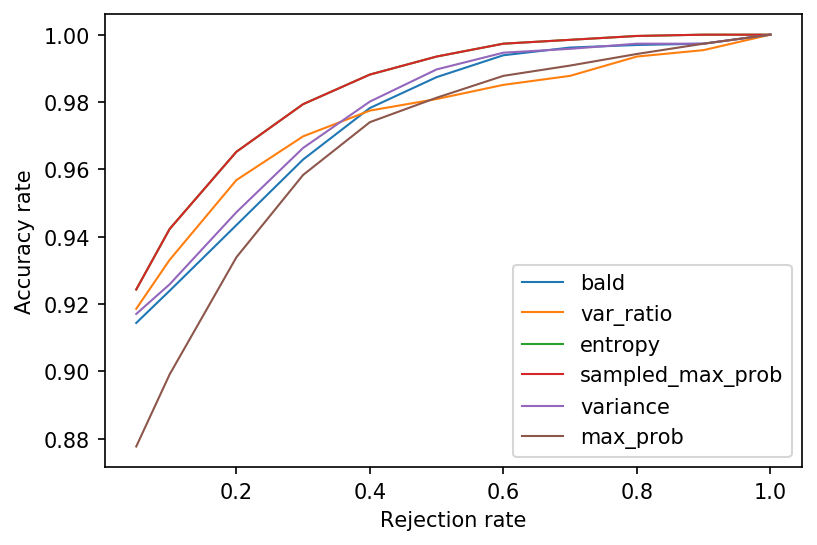

In [8]:
res_dir = '../workdir/results/aug/dev_inference_sst2.json'

with open(Path(res_dir)) as f:
    model_outputs = json.load(f)
    
plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                          np.asarray(model_outputs['true_labels']), 
                          np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                          np.asarray(model_outputs['answers']), )

In [ ]:
np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2).shape

In [15]:
with open(Path(res_dir)/'dev_inference.json') as f:
    model_outputs = json.load(f)